# Hill-curve neutralization
The neutralization curves fit by this package have a Hill-curve like form.

## Definition of curves
The neutralization curve is fit to measurements of the fraction infectivity remaining $f\left(c\right)$ at several different serum concentrations $c$.
The form for the curve is:
$$f(c) = b + \frac{t - b}{1 + (c/m)^s}$$
where $m$ is the midpoint of the curve, $t$ is the "top" of the curve, $b$ is the bottom of the curve, and $s$ is the "slope" or Hill coefficient of the curve.

If the curve spans from completely non-neutralized (100% infectivity remaining) to completely neutralized (0% infectivity remaining), then $t = 1$ and $b = 0$.
In this case, the above equation is identical to 1 minus the [Hill equation defined on Wikipedia](https://en.wikipedia.org/wiki/Hill_equation_(biochemistry)).

However, it will not always be the case that the top and bottom are at 1 and 0.
The reason is that some antibodies and sera do not go to complete neutralization (see [here](https://doi.org/10.1371/journal.ppat.1005110) for a discussion of the phenomenon for HIV).
For such antibodies, $b$ will in general by $>0$.
Therefore, in the fitting you have the option of constraining the top and bottom to $t = 1$ and $b = 0$, or to fit them as free parameters.
The default is to constrain the top to $t = 1$, but fit the bottom $b$ to allow for incomplete neutralization.

Note also that in this definition of a curve, since $f\left(c\right)$ is the fraction **infectivity**, we expect $f\left(c\right)$ to get smaller as the antibody concentration increases.
Just be aware that some papers will plot fraction neutralized rather than fraction infectivity; fraction neutralized is $1 - f\left(c\right)$.

## Fitting using the HillCurve class
The curves are fit using the :mod:class:`hillcurve.HillCurve` class.
Note that for fitting to actual data, you will typically want to instead use :mod:class:`curvefits.CurveFits`, which facilitates fitting to real data, particularly when there are multiple samples being fit at once.
Nonetheless, here we illustrate the basic fitting to a single sample using :mod:class:`hillcurve.HillCurve`.

First, we import the requisite Python modules:

In [1]:
import urllib.request

import pandas as pd

import neutcurve

Now we get example data to plot.
We use as our example the neutralization of wildtype (WT) A/WSN/1933 (H1N1) influenza by the broadly neutralizing antibody FI6v3 as determined in [Fig 6a of Doud et al (2018)](https://www.nature.com/articles/s41467-018-03665-3#Fig6).
The numerical data in that figure in tidy form are [available here](https://github.com/jbloomlab/neutcurve/blob/master/docs/examples/data/Doud_et_al-FI6v3-neutdata.csv); we download the data and get just the measurements for replicate 1 of the wildtype virus against FI6v3:

In [2]:
fi6v3_datafile = ('https://raw.githubusercontent.com/jbloomlab/neutcurve/'
                  'master/docs/examples/data/Doud_et_al-FI6v3-neutdata.csv')

with urllib.request.urlopen(fi6v3_datafile) as f:
    data = (pd.read_csv(f)
            .query('(serum == "FI6v3") & (virus == "WT") & (replicate == "1")')
            [['concentration', 'fraction infectivity']]
            .reset_index(drop=True)
            )

data

,concentration,fraction infectivity
0,0.000205,1.013734
1,0.000478,0.942012
2,0.001115,0.992850
3,0.002602,0.966206
4,0.006071,0.956703
5,0.014165,0.586331
6,0.033052,0.169449
7,0.077122,0.014132
8,0.179952,-0.025386
9,0.419888,-0.032550


As can be seen above, the data give the fraction activity at each antibody concentration (which in this case is in $\mu$g/ml).

Now we initialize a :mod:class:`hillcurve.HillCurve` with these data, which fits the curve:

In [3]:
curve = neutcurve.HillCurve(data['concentration'],
                            data['fraction infectivity'])

We can now look at the values of each of the four parameters that define the curve:

In [4]:
print(f"The top (t) is {curve.top:.3g}")
print(f"The bottom (b) is {curve.bottom:.3g}")
print(f"The midpoint (m) is {curve.midpoint:.3g}")
print(f"The slope (Hill coefficient)s is {curve.slope:.3g}")

The top (t) is 1
The bottom (b) is -0.0282
The midpoint (m) is 0.0173
The slope (Hill coefficient)s is 2.33


Note that the top is exactly 1 because by default it is constrained to that value, whereas the bottom is not quite zero because it is treated a free parameter.
If you want to change whether the top and/or bottom are fixed or fit, you can do that using the `fixtop` and `fixbottom` arguments to :mod:class:`hillcurve.HillCurve` as described in the docs for that class.
For instance, here we fit the top and fix the bottom (it makes very little difference for this particular dataset):

In [5]:
curve2 = neutcurve.HillCurve(data['concentration'],
                             data['fraction infectivity'],
                             fixbottom=0,
                             fixtop=False)

print(f"The top (t) is {curve2.top:.3g}")
print(f"The bottom (b) is {curve2.bottom:.3g}")
print(f"The midpoint (m) is {curve2.midpoint:.3g}")
print(f"The slope (Hill coefficient)s is {curve2.slope:.3g}")

The top (t) is 0.987
The bottom (b) is 0
The midpoint (m) is 0.0169
The slope (Hill coefficient)s is 2.57


We can also get the IC50, which is the concentration where $f\left(c\right) = 0.5$.
The IC50 will be equal to the midpoint $m$ when the top ($t$) is one and the bottom ($b$) is zero, but otherwise it may be different than the IC50.
For this particular dataset, the IC50 is very close to the midpoint:

In [6]:
print(f"The IC50 is {curve.ic50():.3g}")

The IC50 is 0.0169


Note that the method for getting the IC50 (:mod:meth:`hillcurve.HillCurve.ic50`) has some different options for how to handle computing the IC50 if it doesn't fall within the range of the provided concentrations and so cannot be interpolated (see the docs for that method for details).
This doesn't matter for this particular dataset, however, since the IC50 falls within the range of the data.

We can plot the neutralization curve using the :mod:meth:`hillcurve.HillCurve.plot` function.
This returns a matplotlib figure and axis instance:

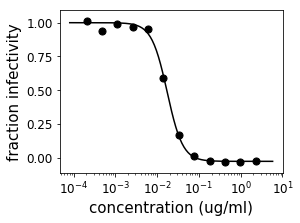

In [7]:
fig, ax = curve.plot(xlabel='concentration (ug/ml)')

If you want to save the figure, do this using its [savefig](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html) method, possibly calling [tight_layout](https://matplotlib.org/users/tight_layout_guide.html) command first if there is clipping.